<a href="https://colab.research.google.com/github/Murcha1990/Raiff_PracticalML_May2023/blob/main/Lecture_9_AllStepsML/Raiff_Pipeline_May.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение задачи поиска оттоковых клиентов

Пройдем по всей схеме:
* загрузка и анализ данных
* построение базовой модели и оценка ее качества
* улучшение качества прогноза
* анализ результатов
* применение модели к новым клиентам

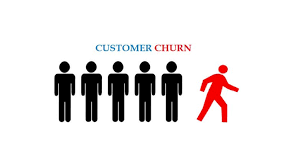

## <font color='green'>1. Загрузка данных (и их первичный анализ)</font>

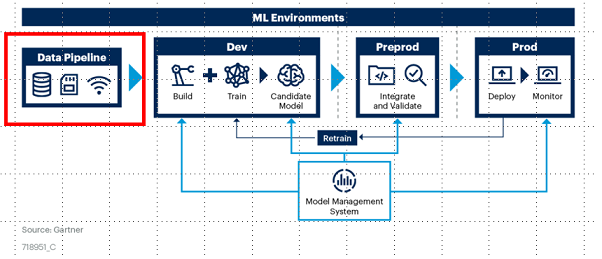

In [ ]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-05-31 11:30:48--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-05-31 11:30:49 (615 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



In [ ]:
!sudo apt update && sudo apt install --yes python3 python3-pip && \
!pip3 install psycopg2-binary

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease [24.3 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2,483 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2,311 kB]
Hit:13 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InReleas

In [ ]:
import psycopg2

conn = psycopg2.connect("""
    host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
    port=6432
    sslmode=verify-full
    dbname=db_clients
    user=mlhs_student
    password=mlhs_student
    target_session_attrs=read-write
""")

In [ ]:
import pandas as pd

query = "SELECT * from public.clients"
data = pd.read_sql_query(query, conn)

conn.close()

In [ ]:
data.head()

,state,accountlength,areacode,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,customerservicecalls,churn
0,KS,128,415,No,Yes,25,265.1,110.0,45.07,197.4,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3,False


## <font color='green'>2.1. Построение базовой модели</font>



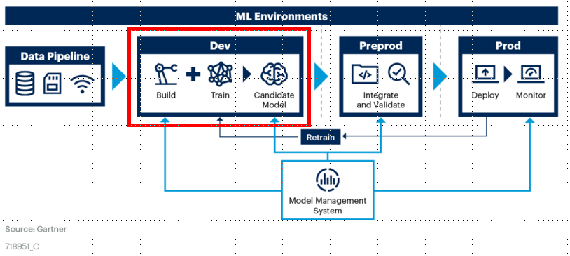

Сформируем матрицу X объект-признак и вектор y целевой переменной.

In [ ]:
X = data.drop('churn', axis=1) # матрица объект-признак
y = data['churn'] # целевая переменная

Выкинем излишние признаки.

In [ ]:
X.drop(['totaldaycharge','totalevecharge','totalnightcharge','totalintlcharge'], axis=1, inplace=True)

Пока что выкинем нечисловые признаки.

In [ ]:
X_full = X.copy()
X = X.drop(['state','areacode','voicemailplan','internationalplan'], axis=1)

Разобъем данные на тренировочную и тестовую части.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

Масштабируем данные.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(Xtrain)

Xtrain = pd.DataFrame(ss.transform(Xtrain), columns=X.columns)
Xtest = pd.DataFrame(ss.transform(Xtest), columns=X.columns)

Xtrain.head()

,accountlength,numbervmailmessages,totaldayminutes,totaldaycalls,totaleveminutes,totalevecalls,totalnightminutes,totalnightcalls,totalintlminutes,totalintlcalls,customerservicecalls
0,-1.404508,-0.584700,-1.883677,1.330852,1.037727,0.401340,1.069609,0.004940,2.768109,-0.595235,-0.427903
1,0.366388,-0.584700,0.294083,0.529165,0.516178,0.401340,2.214376,0.670832,1.051970,-1.417963,0.324616
2,0.518179,1.685101,1.056392,-1.875896,0.093407,0.849774,-0.077125,-0.763398,-0.056369,0.227493,1.829653
3,2.010792,-0.584700,-0.679156,1.681590,-0.402459,0.650470,-0.322994,-0.660953,-0.056369,-0.183871,-0.427903
4,0.290493,-0.584700,0.484660,1.080325,-0.718549,-0.296224,-1.186487,0.056162,0.837453,1.050221,1.077134


Обучим логистическую регрессию на train и сделаем предсказание на новых для нее данных (test).

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression() # объявление модели
model.fit(Xtrain, ytrain) # обучение модели

LogisticRegression()

In [ ]:
pred_test = model.predict_proba(Xtest)[:,1] # предсказание классов

In [ ]:
roc_auc_score(ytest, pred_test)

0.7885585331452751

## <font color='green'>2.2. Валидация модели</font>

Для оценки качества моделей бинарной классификации полезно смотреть на матрицу ошибок.

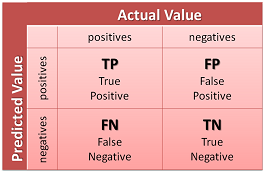

In [ ]:
classes = pred_test > 0.5 # 0.2

confusion_matrix(ytest, classes)

array([[703,   6],
       [114,  11]])

In [ ]:
recall_score(ytest, classes)

0.088

## <font color='green'>3. Улучшение качества моделей и их интерпретация </font>

Выше мы удаляли все категориальные столбцы:

`X = X.drop(['state','areacode','voicemailplan','internationalplan'], axis=1)`

А вдруг там содержится много полезной информации? Попробуем её сохранить.

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_full, y, test_size=0.25, random_state=42)

In [ ]:
Xtrain.head()

,state,accountlength,areacode,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaleveminutes,totalevecalls,totalnightminutes,totalnightcalls,totalintlminutes,totalintlcalls,customerservicecalls
367,MD,45,415,No,No,0,78.2,127.0,253.4,108.0,255.0,100.0,18.0,3.0,1
3103,DE,115,415,No,No,0,195.9,111.0,227.0,108.0,313.2,113.0,13.2,1.0,2
549,OK,121,408,No,Yes,31,237.1,63.0,205.6,117.0,196.7,85.0,10.1,5.0,4
2531,RI,180,415,No,No,0,143.3,134.0,180.5,113.0,184.2,87.0,10.1,4.0,1
2378,OR,112,510,No,No,0,206.2,122.0,164.5,94.0,140.3,101.0,12.6,7.0,3


Закодируем при помощи OneHot-encoding категориальные столбцы.

In [ ]:
categorical = ['state','areacode','voicemailplan','internationalplan']

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

Xtrain_ohe = pd.DataFrame(OH_encoder.fit_transform(Xtrain[categorical]), columns=OH_encoder.get_feature_names_out())
Xtest_ohe = pd.DataFrame(OH_encoder.transform(Xtest[categorical]), columns=OH_encoder.get_feature_names_out())

In [ ]:
Xtrain_ohe.head()

,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,...,state_WI,state_WV,state_WY,areacode_408,areacode_415,areacode_510,voicemailplan_No,voicemailplan_Yes,internationalplan_No,internationalplan_Yes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


Масштабируем числовые столбцы.

In [ ]:
numeric = [col for col in Xtrain.columns if col not in categorical]
numeric

['accountlength',
 'numbervmailmessages',
 'totaldayminutes',
 'totaldaycalls',
 'totaleveminutes',
 'totalevecalls',
 'totalnightminutes',
 'totalnightcalls',
 'totalintlminutes',
 'totalintlcalls',
 'customerservicecalls']

In [ ]:
from sklearn.preprocessing import MinMaxScaler

Xtrain_num = Xtrain[numeric]
Xtest_num = Xtest[numeric]

scaler = MinMaxScaler()
scaler.fit(Xtrain_num)

Xtrain_num = pd.DataFrame(scaler.transform(Xtrain_num), columns=Xtrain_num.columns)
Xtest_num = pd.DataFrame(scaler.transform(Xtest_num), columns=Xtest_num.columns)

Собираем итоговые матрицы признаков.

In [ ]:
Xtrain_good = pd.concat([Xtrain_num, Xtrain_ohe], axis=1)
Xtest_good = pd.concat([Xtest_num, Xtest_ohe], axis=1)

In [ ]:
Xtrain_good.head()

,accountlength,numbervmailmessages,totaldayminutes,totaldaycalls,totaleveminutes,totalevecalls,totalnightminutes,totalnightcalls,totalintlminutes,totalintlcalls,...,state_WI,state_WV,state_WY,areacode_408,areacode_415,areacode_510,voicemailplan_No,voicemailplan_Yes,internationalplan_No,internationalplan_Yes
0,0.190476,0.000000,0.217117,0.718519,0.696728,0.635294,0.623453,0.471831,0.900,0.166667,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.493506,0.000000,0.555141,0.600000,0.624141,0.635294,0.779989,0.563380,0.660,0.055556,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.519481,0.607843,0.673464,0.244444,0.565301,0.688235,0.466649,0.366197,0.505,0.277778,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.774892,0.000000,0.404078,0.770370,0.496288,0.664706,0.433029,0.380282,0.505,0.222222,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.480519,0.000000,0.584721,0.681481,0.452296,0.552941,0.314954,0.478873,0.630,0.388889,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


### <font color='green'>3.1. Логистическая регрессия на всех признаках </font>

In [ ]:
model = LogisticRegression()
model.fit(Xtrain_good, ytrain) 

probs = model.predict_proba(Xtest_good)[:,1]

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(ytest, probs)

0.8303074753173485

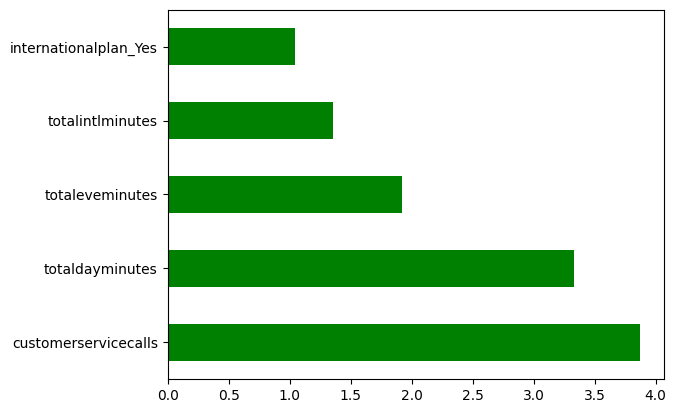

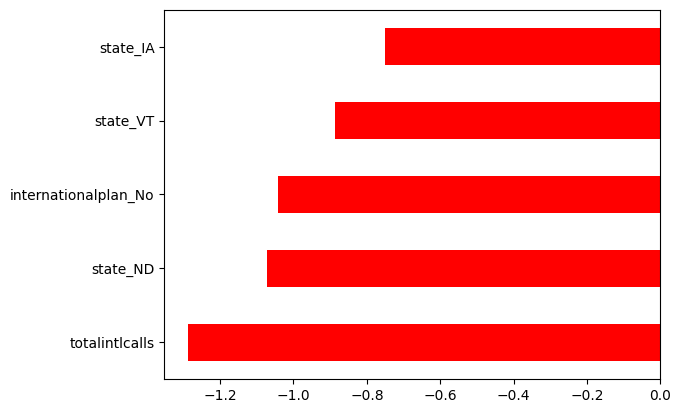

In [ ]:
pd.Series(model.coef_[0], index=Xtrain_good.columns).nlargest(5).plot(kind='barh',color='green')
plt.show()
pd.Series(model.coef_[0], index=Xtrain_good.columns).nsmallest(5).plot(kind='barh',color='red')
plt.show()

### <font color='green'>3.2. CatBoost на всех признаках </font>

In [ ]:
gbm = CatBoostClassifier(iterations=300, #сколько деревьев
                          depth=2, #глубина каждого дерева
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(Xtrain_good, ytrain)
gbm_preds = gbm.predict_proba(Xtest_good)[:,1]

In [ ]:
roc_auc_score(ytest, gbm_preds)

0.9340253878702398

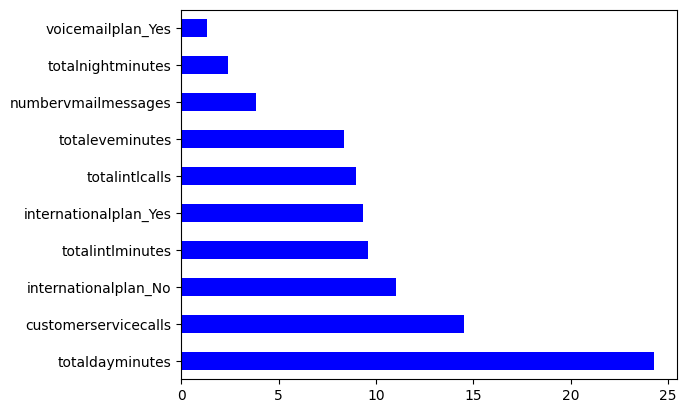

In [ ]:
pd.Series(gbm.feature_importances_, index=Xtrain_good.columns).nlargest(10).plot(kind='barh',color='blue')
plt.show()

### <font color='green'>3.3. CatBoost с внутренним кодированием категориальных признаков </font>

In [ ]:
Xtrain.head()

,state,accountlength,areacode,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaleveminutes,totalevecalls,totalnightminutes,totalnightcalls,totalintlminutes,totalintlcalls,customerservicecalls
367,MD,45,415,No,No,0,78.2,127.0,253.4,108.0,255.0,100.0,18.0,3.0,1
3103,DE,115,415,No,No,0,195.9,111.0,227.0,108.0,313.2,113.0,13.2,1.0,2
549,OK,121,408,No,Yes,31,237.1,63.0,205.6,117.0,196.7,85.0,10.1,5.0,4
2531,RI,180,415,No,No,0,143.3,134.0,180.5,113.0,184.2,87.0,10.1,4.0,1
2378,OR,112,510,No,No,0,206.2,122.0,164.5,94.0,140.3,101.0,12.6,7.0,3


In [ ]:
Xtrain.dtypes

state                    object
accountlength             int64
areacode                  int64
internationalplan        object
voicemailplan            object
numbervmailmessages       int64
totaldayminutes         float64
totaldaycalls           float64
totaleveminutes         float64
totalevecalls           float64
totalnightminutes       float64
totalnightcalls         float64
totalintlminutes        float64
totalintlcalls          float64
customerservicecalls      int64
dtype: object

In [ ]:
cat_features = [0, 2, 3, 4]

In [ ]:
gbm2 = CatBoostClassifier(iterations=300,
                          depth=2,
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm2.fit(Xtrain, ytrain, cat_features=cat_features)

gbm2_preds = model.predict_proba(Xtest)[:,1]

In [ ]:
roc_auc_score(ytest, gbm2_preds)

0.8345049365303243

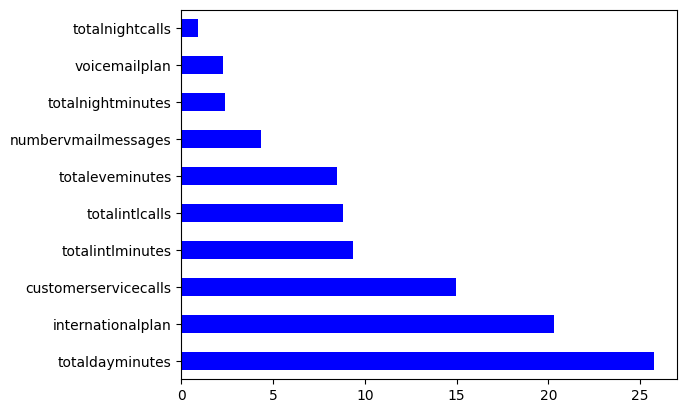

In [ ]:
pd.Series(gbm2.feature_importances_, index=Xtrain.columns).nlargest(10).plot(kind='barh',color='blue')
plt.show()

## <font color='green'>4. Получение предсказаний на новых данных. </font>


Вручную добавим данные о новом клиенте.

In [ ]:
NewData = pd.DataFrame(columns=Xtrain.columns)
NewData = NewData.append({'state' : 'CO', 
                'accountlength' : 71,
                'areacode' : 415,
                'internationalplan' : 'No',
                'voicemailplan' : 'No',
                'numbervmailmessages': 0,
                'totaldayminutes' : 211.2, 
                'totaldaycalls' : 70.0,
                'totaleveminutes' : 252.7,
                'totalevecalls' : 122.0,
                'totalnightminutes' : 225.8,
                'totalnightcalls' : 104.0,
                'totalintlminutes' : 12.3,
                'totalintlcalls' : 3.0,
                'customerservicecalls' : 0 
}, ignore_index=True)

NewData.head()

,state,accountlength,areacode,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaleveminutes,totalevecalls,totalnightminutes,totalnightcalls,totalintlminutes,totalintlcalls,customerservicecalls
0,CO,71,415,No,No,0,211.2,70.0,252.7,122.0,225.8,104.0,12.3,3.0,0


Обработаем данные так же, как делали это при обучении модели.

In [ ]:
NewData_ohe = pd.DataFrame(OH_encoder.transform(NewData[categorical]), columns=OH_encoder.get_feature_names_out())
NewData_num = pd.DataFrame(scaler.transform(NewData[numeric]), columns=NewData[numeric].columns)

NewData = pd.concat([NewData_num, NewData_ohe], axis=1)

Делаем предсказание при помощи бустинга.

In [ ]:
gbm_preds = gbm.predict_proba(NewData)[:,1]

gbm_preds

array([0.05090117])

Согласно модели, этот клиент скорее всего не покинет компанию? А почему?

* Попробуем увеличить число звонков в службу поддержки (поставим 10).

In [ ]:
gbm_preds = gbm.predict_proba(NewData)[:,1]

gbm_preds

array([0.24893636])

* А еще уменьшим `totaldayminutes` до 30.

In [ ]:
gbm_preds = gbm.predict_proba(NewData)[:,1]

gbm_preds

array([0.96165054])

## Shapley values

Shapley values - это концепция, используемая в теории кооперативных игр, которая была адаптирована для применения в машинном обучении. Она позволяет определить вклад каждого признака (или игрока) в прогноз или результат модели машинного обучения.

Давайте представим, что есть модель, которая предсказывает цену дома, и для этого модель использует различные признаки, такие как площадь дома, количество комнат, расстояние до ближайшего парка и т.д. Shapley values помогают определить, насколько каждый из этих признаков влияет на итоговую предсказанную цену дома.

Идея заключается в том, чтобы рассмотреть все возможные комбинации признаков и вычислить, как изменяется предсказание модели, когда каждый признак присоединяется к уже рассмотренным признакам. Затем вычисляется среднее значение этих изменений для каждого признака, и это значение и называется Shapley value.

Shapley values позволяют понять, какие признаки вносят наибольший вклад в предсказания модели и как их комбинации влияют на результат. Это полезный инструмент для объяснения моделей машинного обучения и понимания их внутреннего функционирования.

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 14.9 MB/s eta 0:00:00


In [ ]:
import catboost
from catboost import *
import shap
shap.initjs()

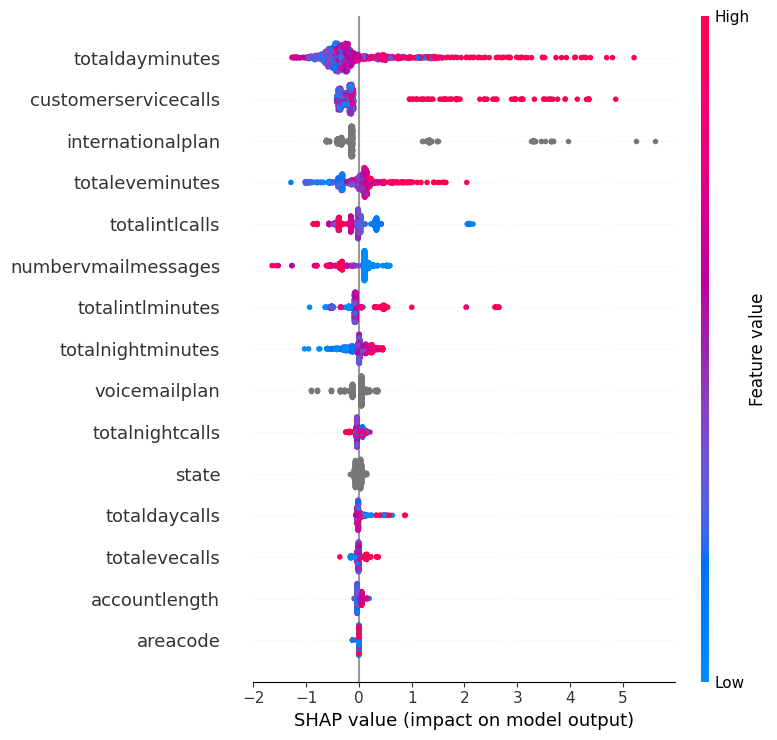

In [ ]:
explainer = shap.TreeExplainer(gbm2)
shap_values = explainer.shap_values(Xtest)

shap.summary_plot(shap_values, Xtest)

In [ ]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[1,:], Xtest.iloc[1,:])

In [ ]:
NewData = pd.DataFrame(columns=Xtrain.columns)
NewData = NewData.append({'state' : 'CO', 
                'accountlength' : 71,
                'areacode' : 415,
                'internationalplan' : 'No',
                'voicemailplan' : 'No',
                'numbervmailmessages': 0,
                'totaldayminutes' : 211.2, 
                'totaldaycalls' : 70.0,
                'totaleveminutes' : 252.7,
                'totalevecalls' : 122.0,
                'totalnightminutes' : 225.8,
                'totalnightcalls' : 104.0,
                'totalintlminutes' : 12.3,
                'totalintlcalls' : 3.0,
                'customerservicecalls' : 0 
}, ignore_index=True)

NewData.head()

explainer = shap.TreeExplainer(gbm2)
shap_values = explainer.shap_values(NewData)

In [ ]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[0,:], NewData.iloc[0,:])